**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../..')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train
from mrcnn.coco            import prep_coco_dataset, CocoConfig ## CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.VERBOSE              = 1
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN32', config=fcn_config)

fcn_model.keras_model.summary()

Using TensorFlow backend.


/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SI

    old_style_scores               :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1_scattered         :  shape: (1, 81, 100, 3)       KB.shape:(1, 81, 100, 3)       Keras Tensor: False

       Normalize_scores() ------------------------------------------------------
         input shape      :  (1, 81, 100, 3)
         reduce_min shape :  (1, 81, 1, 3)
         reduce_max shape :  (1, 81, 1, 3)
             output shape :  (1, 81, 100, 3)

    alt_scores_1_norm(by_class)    :  shape: (1, 81, 100, 3)       KB.shape:(1, 81, 100, 3)       Keras Tensor: False
    alt_scores_1_norm(by_image)    :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False

    Normalize heatmap within each class !-------------------------------------
    in_heatmap_norm :  (?, 81, 256, 256) Keras tensor  False
    normal

### Set weight files

In [2]:
# weights_path= 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'

### DIR_WEIGHTS =  '/home/kbardool/models/train_fcn32_bce/fcn20181210T0000' ### Training with LR=0.00001, BCE Loss WITH L2 Regularization
### files   = ['fcn_0001.h5','fcn_0002.h5','fcn_0003.h5','fcn_0004.h5','fcn_0005.h5','fcn_0009.h5','fcn_0021.h5','fcn_0100.h5','fcn_0157.h5','fcn_0298.h5','fcn_0363.h5']

DIR_WEIGHTS =  '/home/kbardool/models/train_fcn32_bce/fcn20181209T0000' ### Training with LR=0.00001, BCE Loss NO L2 Regularization
files = ['fcn_0001.h5','fcn_0004.h5','fcn_0018.h5','fcn_0101.h5','fcn_0122.h5','fcn_0147.h5']


## Load Weights - 1

In [3]:
weights_path = os.path.join(DIR_WEIGHTS  , files[0])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0001.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0001.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0001.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0001.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [4]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
# weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0753672570,+0.0732019469,+0.0391395502
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0099786073,+0.0095727025,+0.0050128978
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0798814967,+0.0779436901,+0.0417089015
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0086661521,+0.0090576448,+0.0040577273
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0664903075,+0.0673030913,+0.0341749005
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0083525777,+0.0132242423,+0.0045488644
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0624752492,+0.0590094216,+0.0297057889
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0082583493,+0.0137210833,+0.0042746849
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0548835285,+0.0516344942,+0.0243972093
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0085243173,+0.0102266716,+0.0035103566


In [ ]:
from mrcnn.utils import convertHtmlToPdf

### Histograms of Weights - 1st weight file

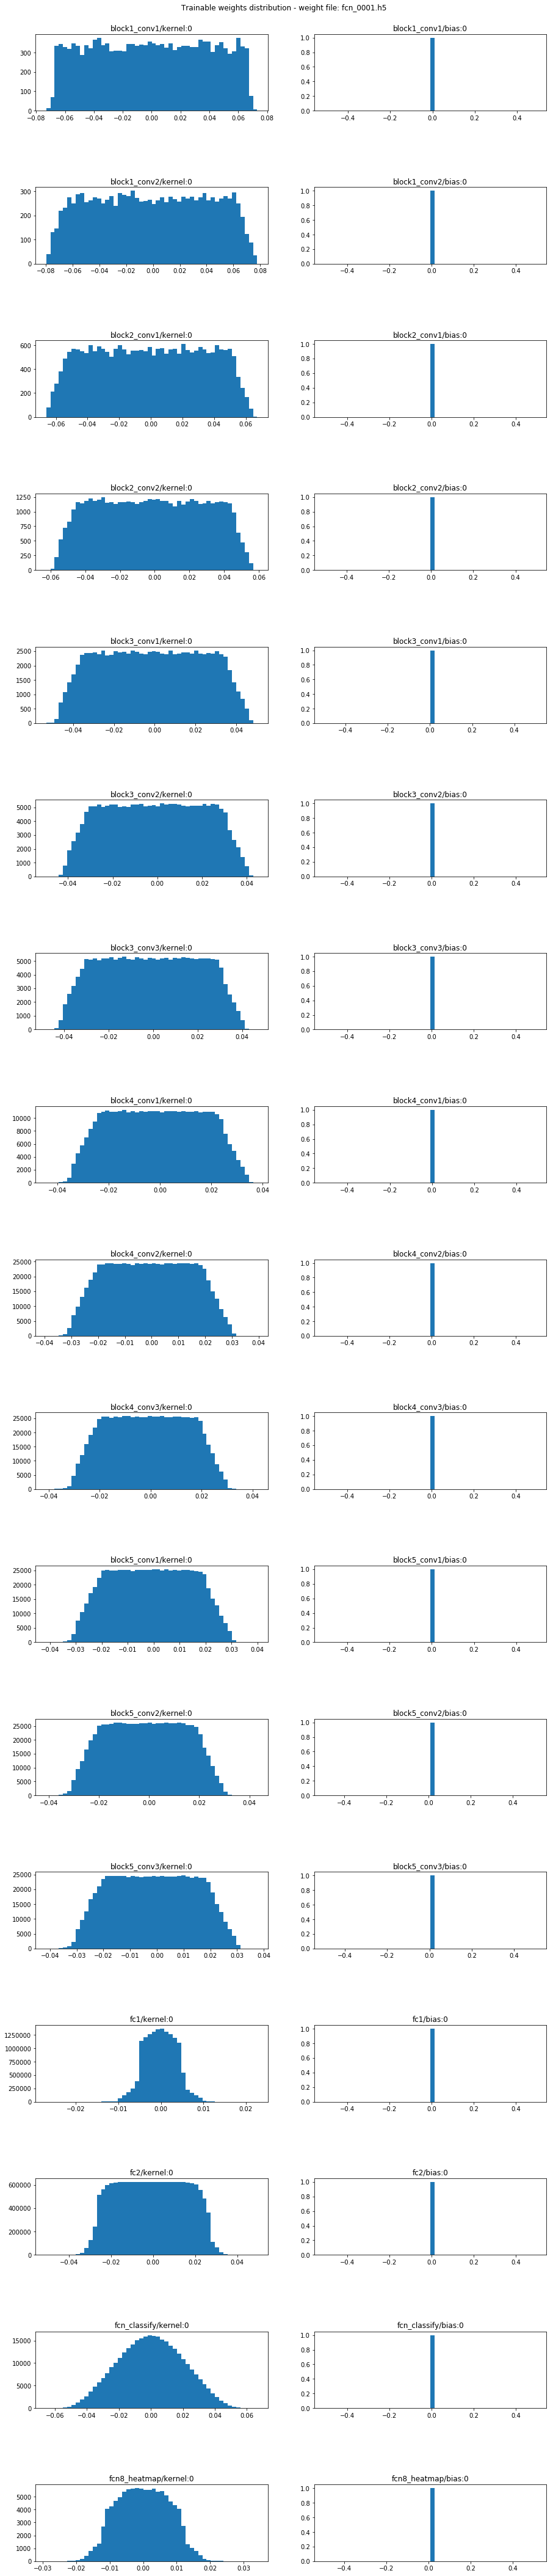

In [5]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[0])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [6]:
weights_path = os.path.join(DIR_WEIGHTS  , files[1])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0004.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0004.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0004.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0004.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [8]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0753905028,+0.0732003227,+0.0391290858
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0111397961,+0.0095579969,+0.0050812517
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0798985139,+0.0778068379,+0.0417080857
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0087537840,+0.0077026864,+0.0039745043
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0665633455,+0.0661999136,+0.0341744497
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0083675049,+0.0115045048,+0.0042111939
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0630839989,+0.0587688275,+0.0297025479
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0082691824,+0.0116980392,+0.0039003405
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0587380752,+0.0544527993,+0.0244007595
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0148559101,+0.0104691926,+0.0033533971


### Histograms of Weights - 2nd weights file

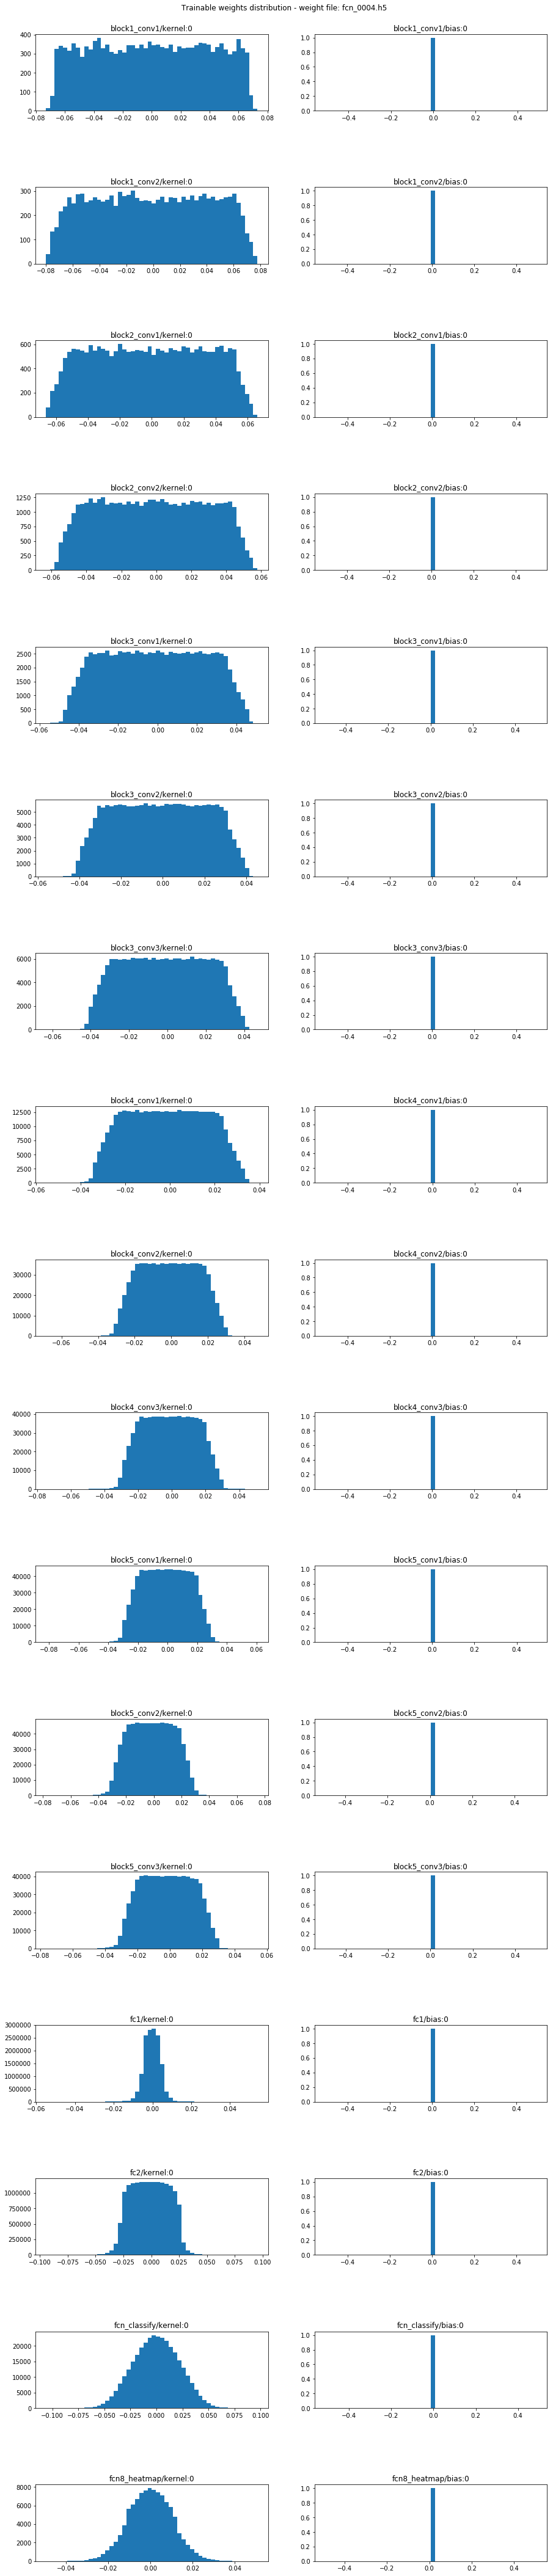

In [7]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [11]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0018.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0018.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0018.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0018.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [12]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0754245594,+0.0759067163,+0.0391197465
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0120704202,+0.0107856225,+0.0051813186
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0798983648,+0.0782165080,+0.0417067930
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0089178476,+0.0082938094,+0.0042199893
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0679137334,+0.0691265315,+0.0341768861
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0083682602,+0.0142277833,+0.0041772574
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0639750659,+0.0587636232,+0.0297013931
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0087369075,+0.0069997213,+0.0035043997
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0596916005,+0.0533446632,+0.0243992656
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0175467562,+0.0146534154,+0.0036048610


### Histograms of Weights - 3rd weight file

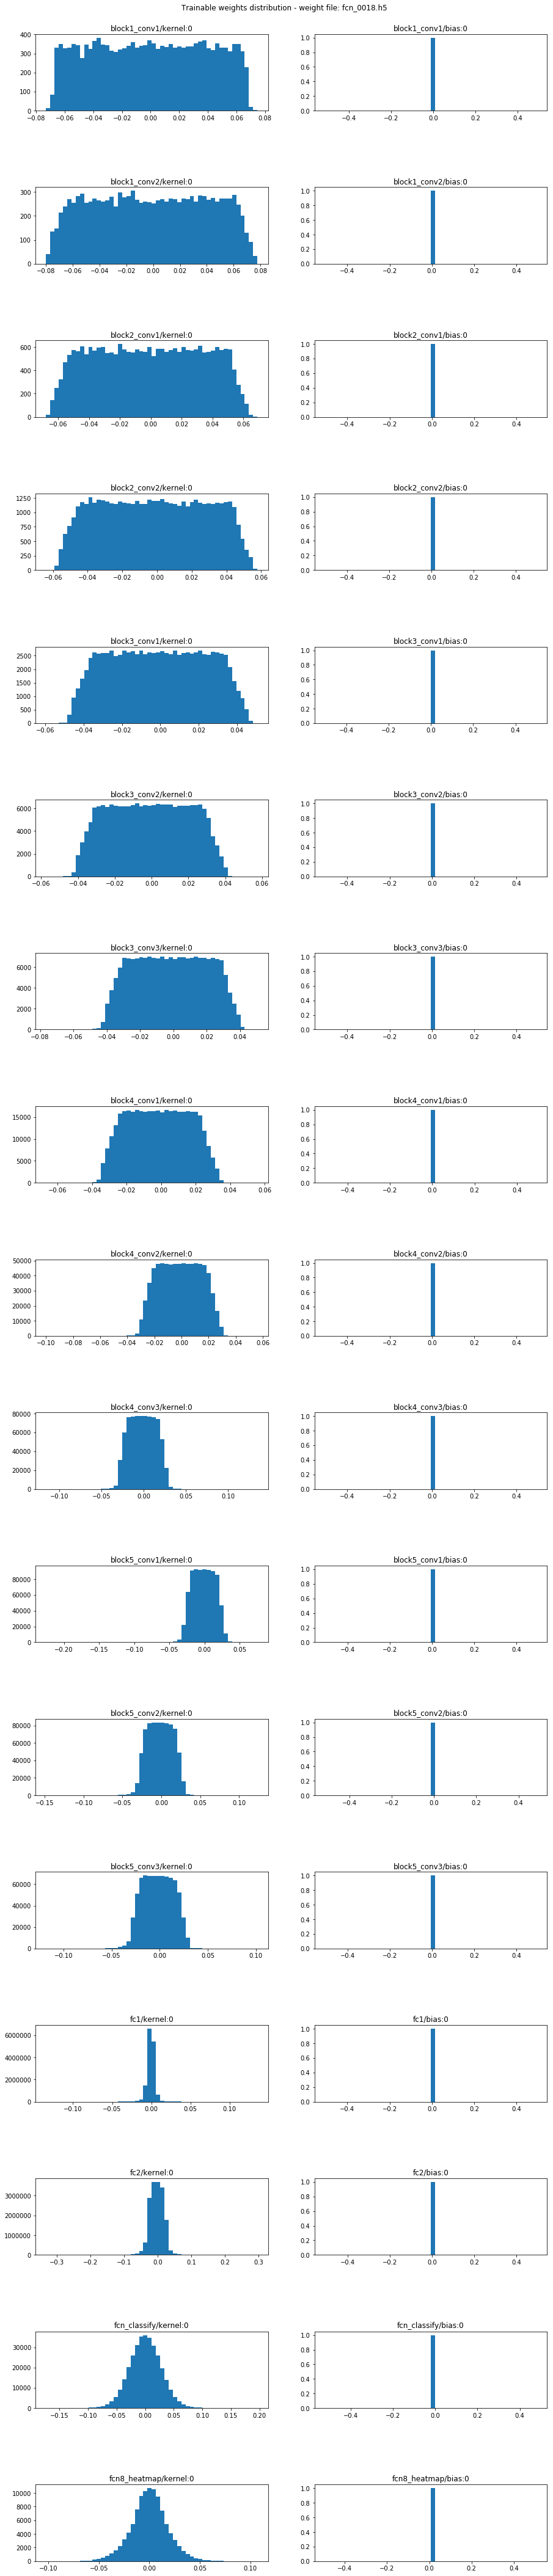

In [13]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [14]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0101.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0101.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0101.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0101.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [15]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0754245594,+0.0759067163,+0.0391197465
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0120621771,+0.0109227654,+0.0051966757
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0798983648,+0.0782165900,+0.0417067930
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0089174835,+0.0085574174,+0.0042623980
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0679141283,+0.0691327825,+0.0341768898
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0083667943,+0.0148520255,+0.0041979272
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0639744326,+0.0587636717,+0.0297013950
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0087514585,+0.0066858134,+0.0034559341
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0596990176,+0.0533373952,+0.0243992638
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0175467562,+0.0133747701,+0.0036340258


### Histograms of Weights

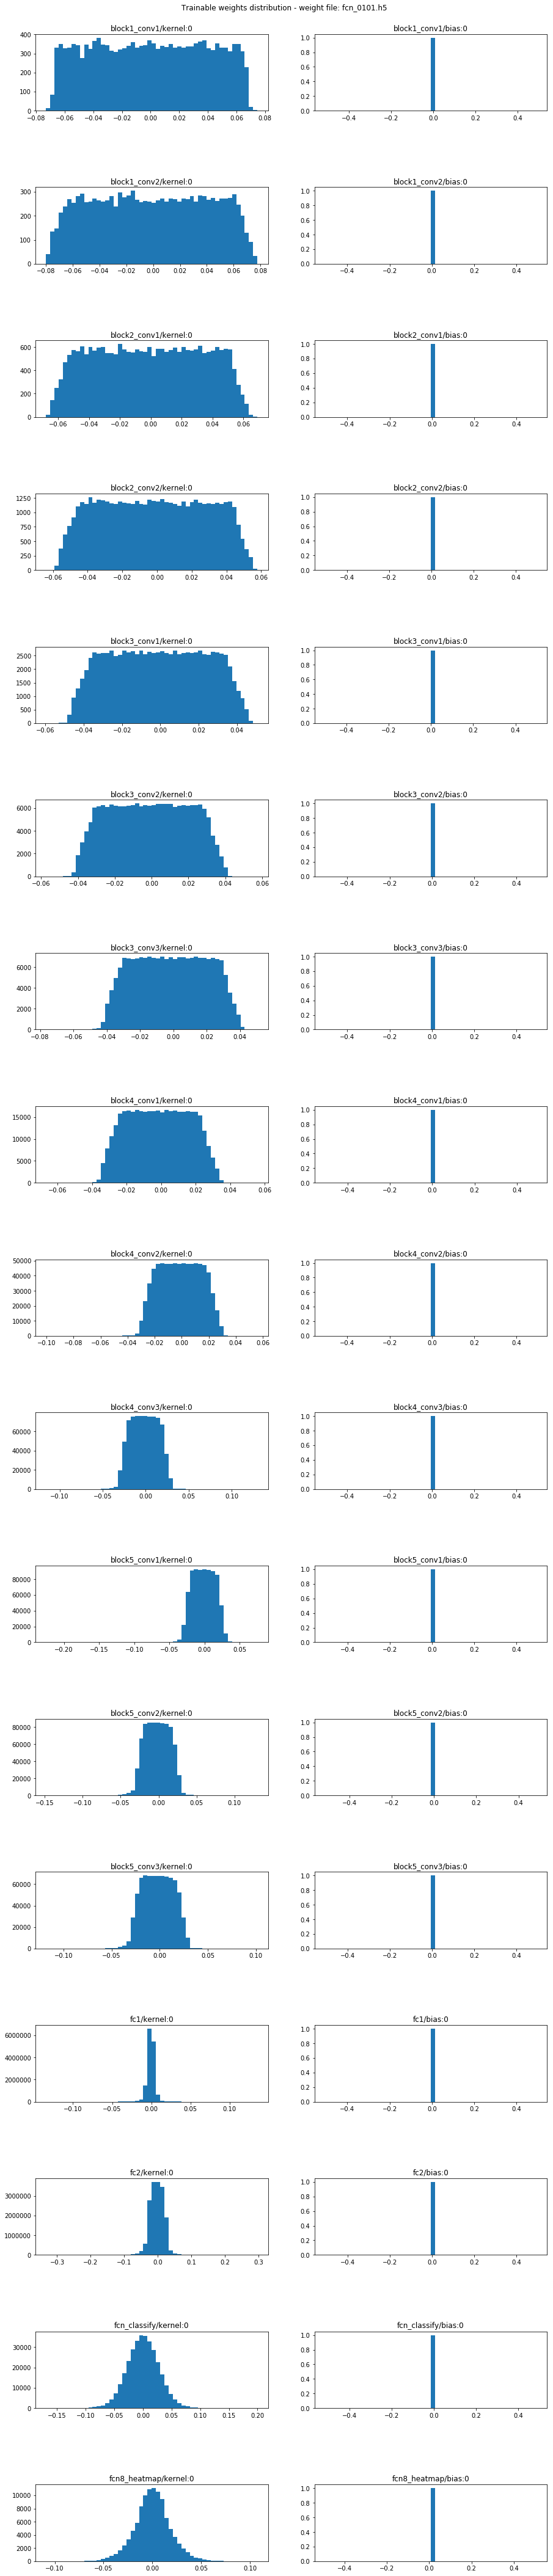

In [16]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [17]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0122.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0122.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0122.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [18]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0999646336,+0.0905185416,+0.0391963609
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0489510857,+0.0396464728,+0.0171181411
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1086188331,+0.0931016132,+0.0420509242
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0354590267,+0.0465098172,+0.0167905726
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1065737680,+0.0801921114,+0.0344944037
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0417622253,+0.0426436812,+0.0154272020
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1206325814,+0.0827732757,+0.0299271233
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0421320796,+0.0438500866,+0.0132130869
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1033748984,+0.0920243710,+0.0246355031
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0362759233,+0.0189281553,+0.0107373707


### Histograms of Weights - 5th weight file

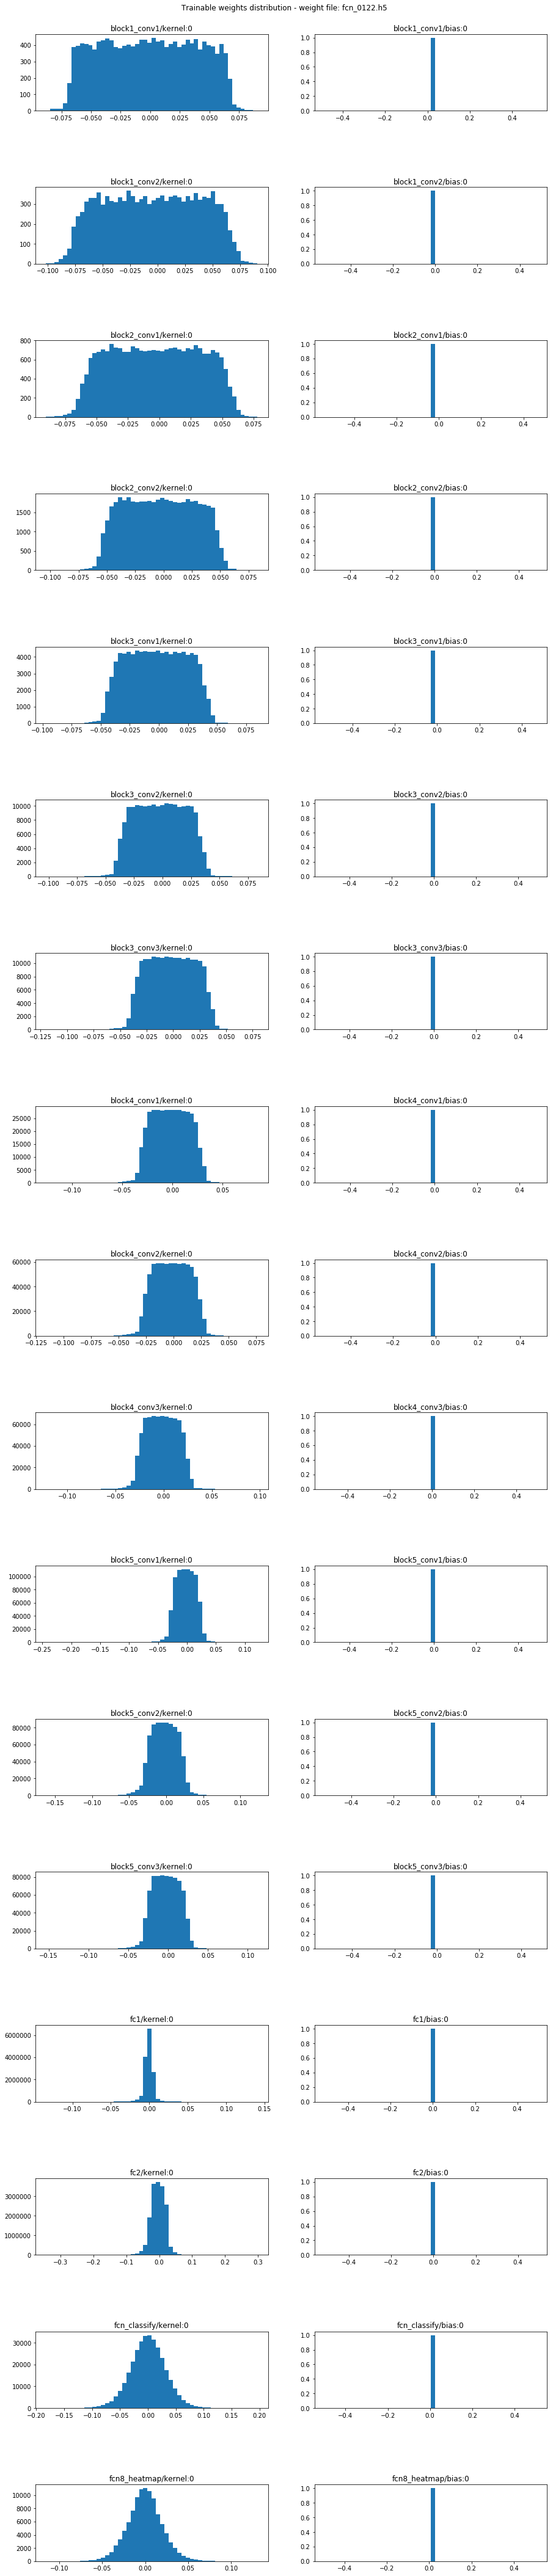

In [19]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [20]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0147.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0147.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181209T0000/fcn_0147.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [21]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0999646336,+0.0905200988,+0.0391963609
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0489511043,+0.0396461561,+0.0171180628
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1086188331,+0.0931016132,+0.0420509428
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0354590267,+0.0465105250,+0.0167905875
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1065740585,+0.0801921114,+0.0344944149
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0417622253,+0.0426434837,+0.0154272951
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1206333712,+0.0827732757,+0.0299271252
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0421320796,+0.0438501649,+0.0132130198
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1033745334,+0.0920243710,+0.0246355031
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0362759233,+0.0189282708,+0.0107373437


### Histograms of Weights - 6th weight file

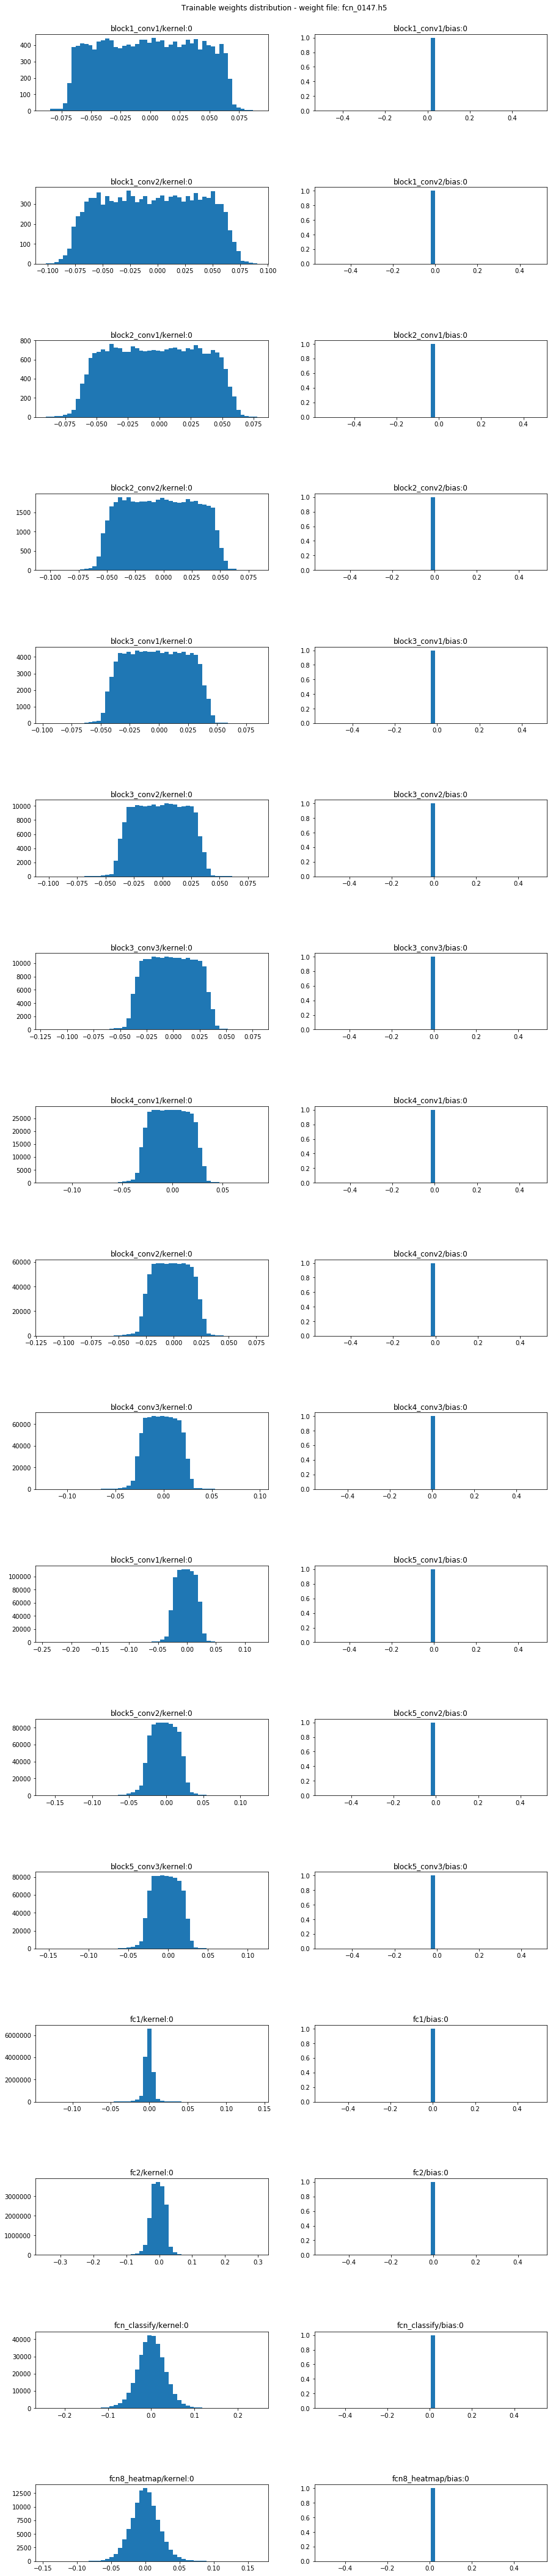

In [22]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [23]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

IndexError: list index out of range

### Review Weight Stats - 7th weight file

In [59]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0000000000,+0.0000000001,+0.0000000000
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0117330505,+0.0083170217,+0.0058874218
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0000000000,+0.0000000000,+0.0000000000
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0106720151,+0.0089832973,+0.0053441464
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0000000000,+0.0000000000,+0.0000000000
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0098085292,+0.0089294491,+0.0050294073
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0000000000,+0.0000000000,+0.0000000000
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0096926168,+0.0104118576,+0.0048742737
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0000000000,+0.0000000000,+0.0000000000
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0098535465,+0.0102784121,+0.0049831597


### Histograms of Weights - 7th weight file

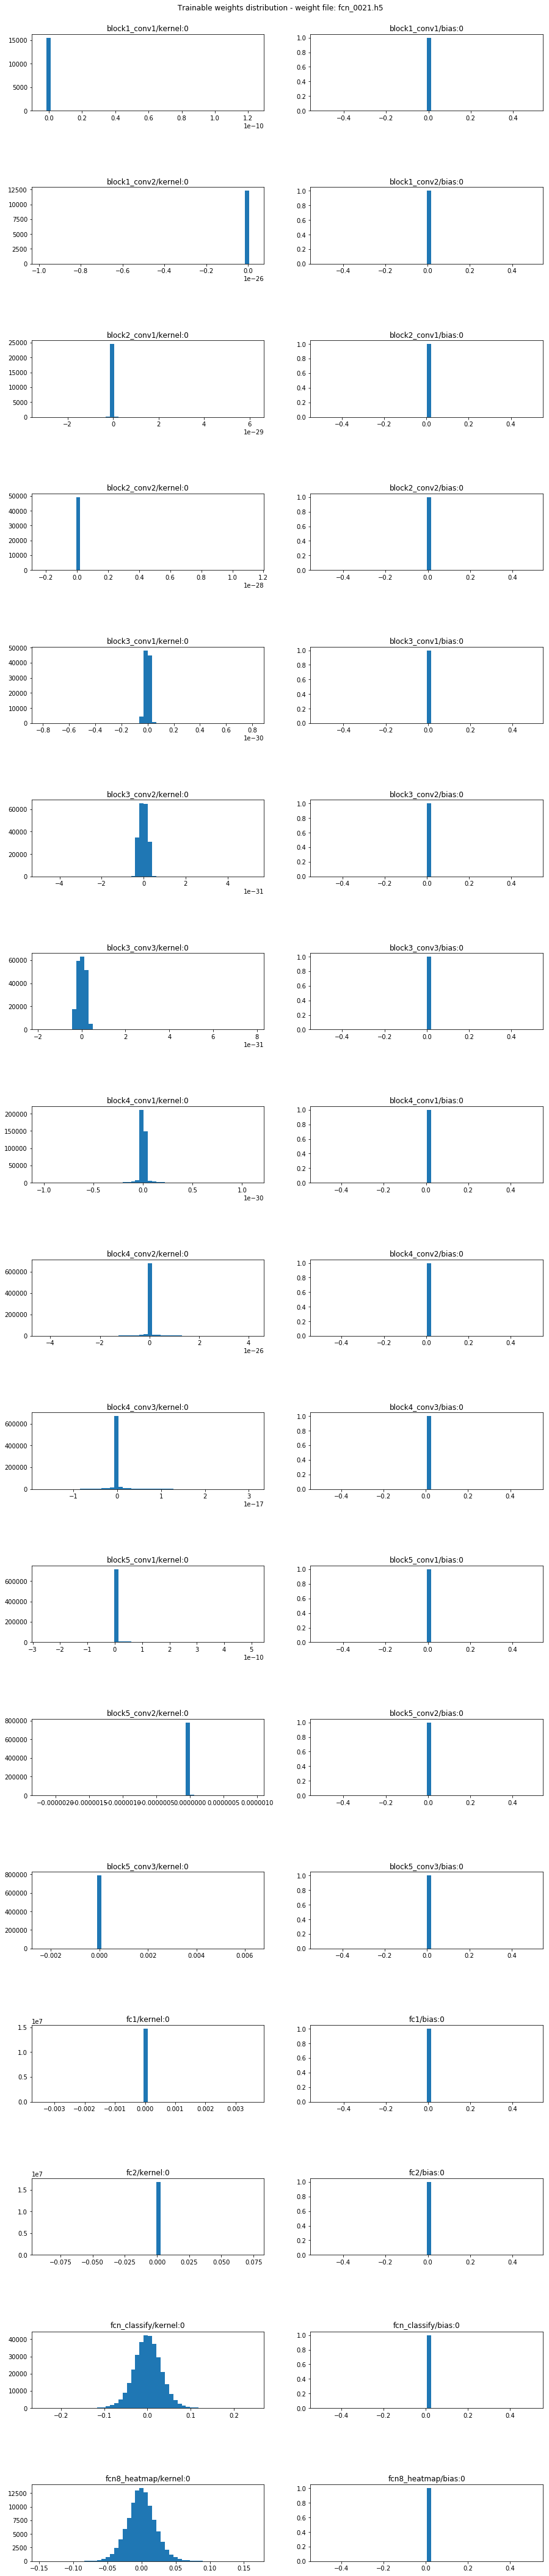

In [58]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)

## Load Weights - 8th weight file

In [60]:
weights_path = os.path.join(DIR_WEIGHTS  , files[7])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn32_bce/fcn20181210T0000/fcn_0100.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn32_bce/fcn20181210T0000/fcn_0100.h5
    Weights file loaded: /home/kbardool/models/train_fcn32_bce/fcn20181210T0000/fcn_0100.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 8th weight file

In [61]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0000000000,+0.0000000000,+0.0000000000
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0117330505,+0.0083170217,+0.0058874218
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0000000000,+0.0000000000,+0.0000000000
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0106720151,+0.0089832973,+0.0053441464
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0000000000,+0.0000000000,+0.0000000000
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0098085292,+0.0089294491,+0.0050294073
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0000000000,+0.0000000000,+0.0000000000
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0096926168,+0.0104118576,+0.0048742737
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0000000000,+0.0000000000,+0.0000000000
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0098535465,+0.0102784121,+0.0049831597


### Histograms of Weights - 8th weight file

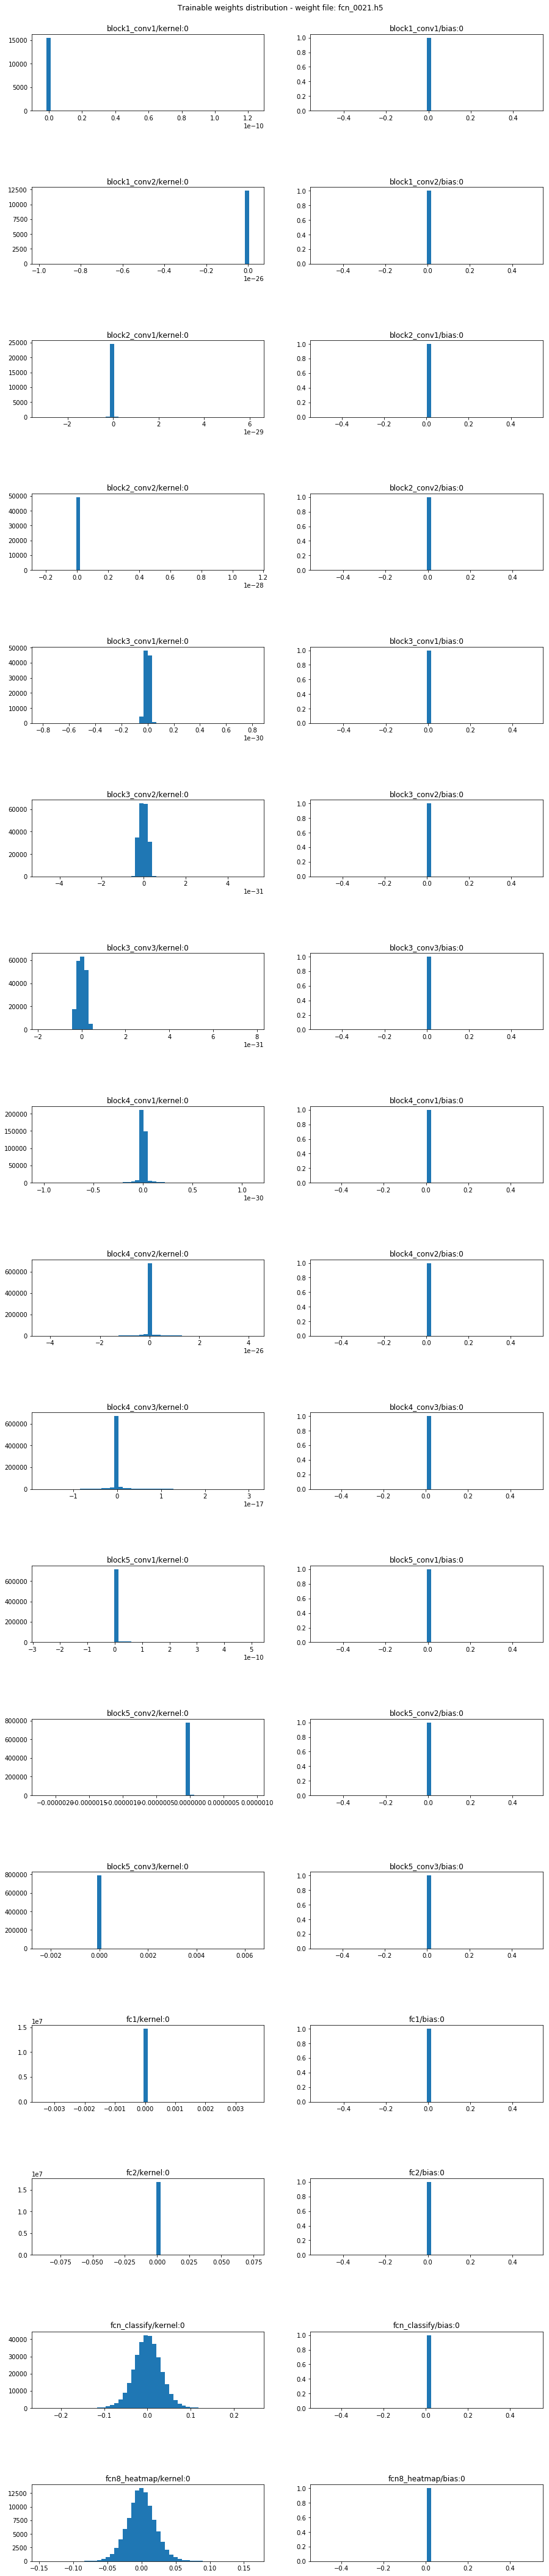

In [58]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)